<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A11_%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E5%91%A8%E5%87%A1%E5%89%9B/%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92_0809.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imagenet

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile #解壓縮一個zip檔案
path = "/content/drive/MyDrive/AI應用程式工程師/0619_周凡剛_機器學習/train.zip"
f = zipfile.ZipFile(path)
f.extractall() #將zip檔案中的所有檔案和資料夾解壓縮到當前工作目錄

train/dog.8030.jpg


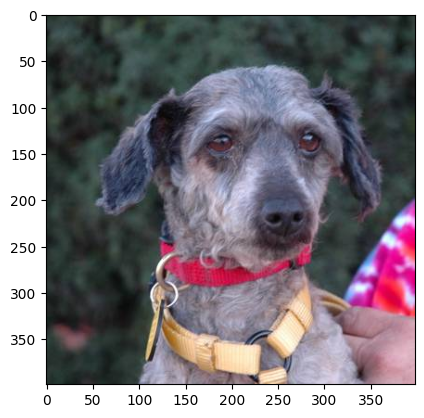

In [9]:
#檢查資料夾任意一張圖片
import glob #目錄中查找檔案的方式
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[3000]))
print(fs[3000])

In [5]:
#訓練資料、驗證資料、測試資料切割與準備
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs) #將這些圖片的路徑隨機打亂，以確保數據的隨機性
cats = glob.glob("train/cat.*")
random.shuffle(cats)

# cat: 1000 dog: 1000
train = pd.DataFrame({
    "filename":dogs[:900] + cats[:900], #訓練集包含前900張狗的圖片和前900張貓的圖片，共1800張圖片
    "class":["dog"] * 900 + ["cat"] * 900
})
validate = pd.DataFrame({ #驗證集包含第900張到第950張的狗的圖片和貓的圖片，共100張圖片
    "filename":dogs[900:950] + cats[900:950],
    "class":["dog"] * 50 + ["cat"] * 50
})
test = pd.DataFrame({ #測試集包含第950張到第1000張的狗的圖片和貓的圖片，共100張圖片
    "filename":dogs[950:1000] + cats[950:1000],
    "class":["dog"] * 50 + ["cat"] * 50
})

[preprocess](https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py)

1. caffe:   轉BGR後 - mean = [103.939, 116.779, 123.68], -1xx~+1xx間

2. tf: -1~1

3. torch: $\mu = 0, σ=1$


偷眼睛就得偷預處理

ImageDataGenerator一般會帶一個參數 rescale=1/255.0, 但我這裡是偷 我帶的是preprocessing_function


## 數據增強

妳的圖片太少的時候可以用原本圖片做出假圖片

Found 1800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


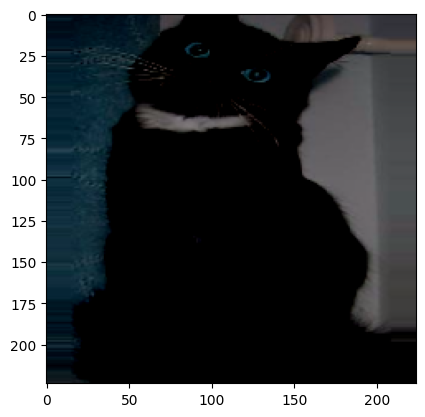

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# 資料增強: zoom:放大(1.2) shear:偏斜(0.2) 水平翻轉
train_datagen = ImageDataGenerator(
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 測試資料是沒有動的
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 另外一個叫做flow_from_directory
# flow_from_dataframe: 檔案路徑要叫filename 答案class
training_set = train_datagen.flow_from_dataframe(
    train,
    ".",
    # 每一張圖片都縮到(224, 224): 根據當初imagenet的訓練大小
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    # 她會直接幫妳dog/cat這字串轉成0/1
    class_mode="sparse")
validate_set = test_datagen.flow_from_dataframe(
    validate,
    ".",
    # 每一張圖片都縮到(224, 224)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")
test_set = test_datagen.flow_from_dataframe(
    test,
    ".",
    # 每一張圖片都縮到(112, 112)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")
plt.imshow(training_set.__next__()[0][0] / 255.0)

(32, 224, 224, 3)


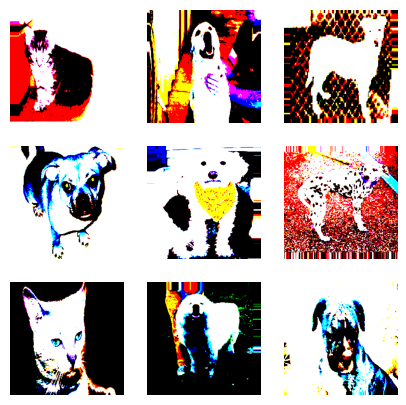

In [10]:
# 秀出訓練資料被數據增強以後產生的圖片
import matplotlib.pyplot as plt
# __next__: (圖片, 答案)
batch = training_set.__next__()[0]
print(batch.shape)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis("off")

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3)) #include_top=False vgg16的分類器我們不採用
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [17]:
# 控制訓練次數: 控制過擬合程度
# 不希望死背/看稀少, 檢查test
# 訓練次數過多反而會變差
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    # 檢查test資料, 如果我10次都沒有表現更好, 停
    EarlyStopping(patience=10, restore_best_weights=True)
]
# 不想要進度條, verbose=2
model.fit(training_set,
     epochs=3, #5 or 150
     validation_data=validate_set,
     callbacks=callbacks,
     verbose=2)

Epoch 1/3
57/57 - 24s - loss: 0.0609 - accuracy: 0.9800 - val_loss: 0.0577 - val_accuracy: 0.9800 - 24s/epoch - 423ms/step
Epoch 2/3
57/57 - 24s - loss: 0.0686 - accuracy: 0.9756 - val_loss: 0.0712 - val_accuracy: 0.9600 - 24s/epoch - 421ms/step
Epoch 3/3
57/57 - 23s - loss: 0.0565 - accuracy: 0.9872 - val_loss: 0.0612 - val_accuracy: 0.9700 - 23s/epoch - 400ms/step


In [18]:
model.evaluate(x=test_set)

4/4 [==============================] - 1s 109ms/step - loss: 0.0712 - accuracy: 0.9600


[0.07121565192937851, 0.9599999785423279]

In [19]:
# 你要看到機率不是always 1.00e+00
model.predict(test_set)

4/4 [==============================] - 1s 137ms/step


array([[1.78638333e-03, 9.98213649e-01],
       [9.94552553e-01, 5.44742215e-03],
       [7.27075756e-01, 2.72924274e-01],
       [8.80958542e-05, 9.99911904e-01],
       [9.14521158e-01, 8.54788199e-02],
       [3.07212453e-02, 9.69278693e-01],
       [4.97260885e-07, 9.99999523e-01],
       [9.62841034e-01, 3.71589586e-02],
       [9.99955177e-01, 4.48467908e-05],
       [9.96950090e-01, 3.04988562e-03],
       [8.48959200e-03, 9.91510391e-01],
       [9.92305458e-01, 7.69457640e-03],
       [8.13214749e-04, 9.99186814e-01],
       [9.97992039e-01, 2.00802274e-03],
       [9.99976754e-01, 2.32142265e-05],
       [9.97313440e-01, 2.68651964e-03],
       [9.99993563e-01, 6.48799278e-06],
       [9.99464571e-01, 5.35462517e-04],
       [6.45262699e-05, 9.99935508e-01],
       [3.22350446e-04, 9.99677658e-01],
       [7.02722680e-09, 1.00000000e+00],
       [4.60030606e-07, 9.99999523e-01],
       [6.04502759e-07, 9.99999404e-01],
       [9.99756277e-01, 2.43759176e-04],
       [5.739674

In [ ]:
import numpy as np
def getdata(df):
    img_ori, img_preprocess, target = [], [], []
    for fn, c in zip(df["filename"], df["class"]):
        img = Image.open(fn).resize((224, 224)).convert("RGB")
        img_np = np.array(img)
        # original
        img_ori.append(img_np)
        img_np_pre = preprocess_input(img_np)
        # preprocess
        img_preprocess.append(img_np_pre)
        if c == "cat":
            target.append(0)
        else:
            target.append(1)
    return (np.array(img_ori), np.array(img_preprocess), np.array(target))
img_ori, x_test, y_test = getdata(test)
print(img_ori.shape)
print(x_test.shape)
print(y_test.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)
(100,)


In [ ]:
pre = model.predict(img_ori).argmax(axis=-1)
pre

4/4 [==============================] - 0s 131ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
np.nonzero(y_test != pre)

(array([11, 14, 15, 36, 49, 61]),)

[11 14 15 36 49 61]


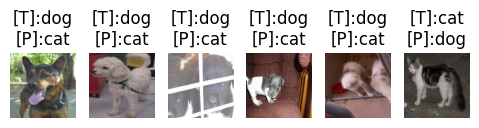

In [ ]:
import numpy as np
trans = ["cat", "dog"]
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
print(idx)
plt.figure(figsize=(10, 10))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = img_ori[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])

url:https://i2.kknews.cc/kYXbr-qongbUjDHx33rMOJx6Lafd-LuAaIf_V8U/0.jpg
1/1 [==============================] - 1s 706ms/step
cat 的機率: 0.362
dog 的機率: 0.638


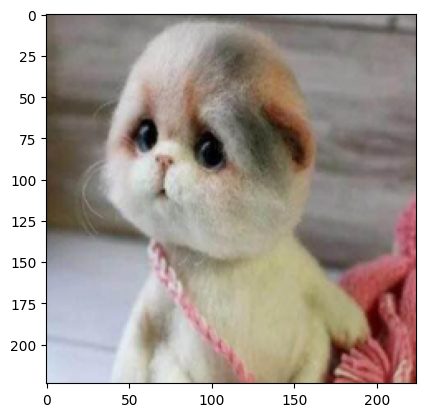

In [ ]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)